# CS105 Survey
Members: John Huh, Emily Mai, Calvin Ng

# Data Pre-processing

In [256]:
# import necessary libraries
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
import umap
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx
%matplotlib inline

In [2]:
# load the data
def load_data(start=0, end=10000, path="data/yelp_academic_dataset_review.json"):
    datafile = open(path, encoding='utf-8')
    data = []
    for i, line in tqdm(enumerate(datafile)):
        if i in list(range(start, end)):
            data.append(json.loads(line))
        if i > end:
            break
    datafile.close()
    df = pd.DataFrame(data)
    return df

# Text Embedding

In [3]:
# function to embedd the reviews
def load_embeddings(dataframe, column):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    messages = np.asarray(dataframe[column])
    tensor_list = tf.convert_to_tensor(messages)
    embeddings = np.array(embed(tensor_list)).tolist()
    # return the reviews followed by their respective embeddings
    return messages, embeddings

# function to show the embeddings
def show_embeddings(n, reviews, embeddings):
    # print first n review embeddings
    for i, message_embedding in enumerate(embeddings[:n]):
        print("Message: {}".format(reviews[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Batch Processing

In [358]:
# function to process batches of the data
def batch_process(step=10000, stop=50000):
    review_df = pd.DataFrame()
    # generate ranges (i.e. [(0,1000), (1000,2000), ...]
    batches = [(n, min(n + step, stop)) for n in range(0, stop, step)]
    for s, e in batches:
        print("Processing {}:{}...".format(s, e))
        # load data and embeddings
        df = load_data(s, e)
        text, embeddings = load_embeddings(df, "text")
        # store embeddings in dataframe
        df["embedding"] = embeddings
        # add new embeddings to main dataframe
        review_df = pd.concat([review_df, df], ignore_index=True, sort=False)

    # save to pickle file to avoid reprocessing of embeddings
    review_df.to_pickle("data/data.pkl")
    print(review_df)


# batch_process()

# if you have the pkl file just run this:
review_df = pd.read_pickle("data/data.pkl")
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,embedding
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,"[-0.018010487779974937, -0.050318099558353424,..."
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,"[-0.04308006912469864, -0.019955946132540703, ..."
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,"[-0.01958566904067993, -0.04187788814306259, -..."
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,"[-0.044252898544073105, -0.07447142153978348, ..."
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,"[0.013128811493515968, -0.01807524263858795, 0..."


# Exploratory Data Analysis (EDA)

Total number of Review per Restaurant


bZiIIUcpgxh8mpKMDhdqbA    366
H_RM2u1WWGU1HkKZrYq2Ow    295
jREzLrIEkc4jQKLfYMJ0gg    184
VPqWLp9kMiZEbctCebIZUA    180
oz882XuZCxajKo64Opgq_Q    180
                         ... 
_EbOP_aB6yVh9ORw6nvnRg      1
Vy936nz51mtKpVp-8VZtvw      1
w8bhTx63qPuE905UyB70Hw      1
EzyEb4MvMUuxAF5xaalNPQ      1
qQzsCfDBprrJTk5Ij_ZN6Q      1
Name: business_id, Length: 9032, dtype: int64

Average star received for most reviewed restaurant: 4.26775956284153


Text(0, 0.5, 'Total number of Stars')

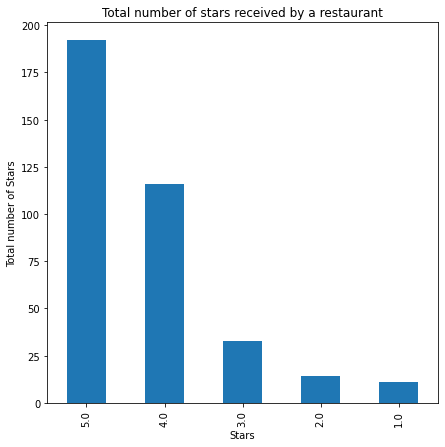

In [376]:
# calculate total reviews per restaurant using business_id
total_reviews = review_df["business_id"].value_counts()
print("Total number of Review per Restaurant")
display(total_reviews)

# find most popular restaurant based on reviews
mostpopRest = review_df.loc[(review_df['business_id'] == 'bZiIIUcpgxh8mpKMDhdqbA')]

# calculate total stars and avg. star for most popular restaurant
revDist = mostpopRest['stars'].value_counts()
revMean = mostpopRest['stars'].mean()
print("Average star received for most reviewed restaurant: {}".format(revMean))

# plot distribution of number of stars
plot = revDist.plot(kind='bar', figsize=(7, 7),title="Total number of stars received by a restaurant")
plot.set_xlabel("Stars")
plot.set_ylabel("Total number of Stars")

In [377]:
# calculate how requent a user leaves a review
freqRev = mostpopRest['user_id'].value_counts()
print(freqRev)

jbEEMwW0gjCfuc1qRmXtmA    1
ACCp4HzHfkleU9I8ynb5qg    1
p2PpidC2QHa9KVGVAVcxzA    1
wPJPd8yB5PCnjAGg3WLAtg    1
cEiMXQHs7j-tUCxXNoGEXQ    1
                         ..
coKnuxLznH0FHb34m4ZLCw    1
PluuoC0vKMq_159qjFiR-A    1
3ZZpqh6A0z-SHNQNSqS_UA    1
omHM2jCXBoy5k9oMTdJRSg    1
eXno8ExEyqA0k0V_enxFEA    1
Name: user_id, Length: 366, dtype: int64


<AxesSubplot:xlabel='date', ylabel='stars'>

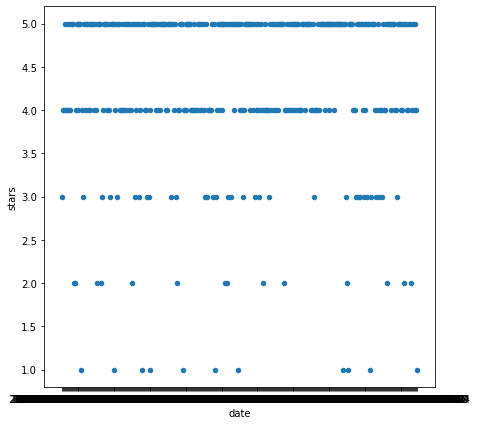

In [378]:
# generate graph for rating over time
timeSP = mostpopRest.set_index(pd.DatetimeIndex(mostpopRest['date']))
timeSP.plot.scatter(x='date', y='stars', figsize=(7, 7))

# Reviews Clustering

In [334]:
# clustering using Gaussian Mixture Models
# grid search hyper-parameters and return best model and scores
def gmm_model_selection(n_clusters, X):
    lowest_bic = np.infty
    bic = []
    assert X.shape[0] >= n_clusters
#     cv_types = ['spherical', 'tied', 'diag', 'full']
#     for cv_type in cv_types:
    cv_type = 'diag'
    for k in range(1, n_clusters):
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    print("Num components chosen by GMM: {}".format(best_gmm.n_components))
    return best_gmm, bic

# clustering using DBSCAN
# grid search hyper-parameters and return best model and scores
def dbscan_model_selection(X):
    lowest_ss = np.infty
    scores = []
    for epsilon in [0.85, 0.9, .95, 1]:
        score_row = []
        for min_samples in [3, 5, 7, 9]:
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
            labels = db.labels_
            score_row.append(metrics.silhouette_score(X, labels))
            if score_row[-1] < lowest_ss:
                lowest_ss = score_row[-1]
                best_db = db
        scores.append(score_row)
    labels = best_db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    return best_db, np.array(scores)

# visualization for clusters
def plot_tsne(gmm, X, Y, messages):
    # dimensionality reduction
    x_reduced = TSNE(n_components=2).fit_transform(X)

    # plot points and their respective colors according to cluster
    color_iter = iter([plt.cm.tab20(i) for i in range(20)])
#     color_iter = itertools.cycle(['lightblue', 'lightgreen', 'darkorange', 'grey', 'purple', 'darkgreen', 'darkblue','darkred','pink'])
    for i, mean in enumerate(gmm.means_):
        if not np.any(Y == i):
            continue
        plt.scatter(x_reduced[Y == i, 0], x_reduced[Y == i, 1], 8, color=next(color_iter))
    csr = mplcursors.cursor(hover=True)
    csr.connect("add", lambda sel: sel.annotation.set_text(messages[sel.target.index]))
    plt.xticks(())
    plt.yticks(())
    plt.title(f'Selected GMM: {gmm.covariance_type} model, 'f'{gmm.n_components} components')
    plt.show()

In [342]:
# load data for one business
data = pd.read_pickle("data/data.pkl")
data = data[data["business_id"] == "bZiIIUcpgxh8mpKMDhdqbA"]
X = np.array(data["embedding"].tolist())
# X = TSNE(n_components=2).fit_transform(X)
X = umap.UMAP(n_components=10).fit_transform(X)

Num components chosen by GMM: 15


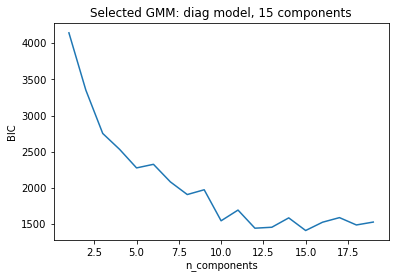

In [343]:
# run once to get best model using GMMs
best_gmm, bic = gmm_model_selection(20, X)
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, 'f'{best_gmm.n_components} components')
plt.plot(np.arange(1,20), bic)
plt.xlabel("n_components") 
plt.ylabel("BIC") 
plt.show()

# run once to get best model using DBSCAN
# best_db, scores = dbscan_model_selection(X)
# labels = best_db.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# plt.title('Selected DBSCAN: epsilon={}, min_samples={}, {} components, {} outliers'.format(best_db.eps,best_db.min_samples,n_clusters_,n_noise_))
# ax = sns.heatmap(scores, linewidth=0.3, xticklabels=[3, 5, 7, 9], yticklabels=[0.85, 0.9, .95, 1])
# plt.xlabel("min_samples") 
# plt.ylabel("epsilon") 
# plt.show()

In [344]:
# fit and predict GMM on data
model = GaussianMixture(n_components=15, covariance_type='diag', tol=1e-6, max_iter=10000, verbose=2)
best_gmm = model.fit(X)
Y = best_gmm.predict(X)  # contains generated cluster labels

Initialization 0
  Iteration 10	 time lapse 0.06300s	 ll change 0.00022
  Iteration 20	 time lapse 0.02200s	 ll change 0.00007
Initialization converged: True	 time lapse 0.09300s	 ll 0.52865


# Anomaly Detection

In [126]:
def gmm_anomalies(data, posterior, threshold):
    max_posterior = np.amax(posterior, axis=1)
    indices = np.argwhere(max_posterior < threshold).flatten()
    anomalies = data["text"].take(indices)
    return anomalies

def lof_anomalies(data, X):
    model = LocalOutlierFactor(contamination=0.01, n_neighbors=5, metric="l2")
    outlier_scores = model.fit_predict(X)
    print(model.negative_outlier_factor_[outlier_scores == -1])
    anomalies = data[outlier_scores == -1]
    return anomalies["text"]

def dbscan_anomalies(labels):
    indices = np.argwhere(labels == -1).flatten()
    anomalies = data["text"].take(indices)
    return anomalies

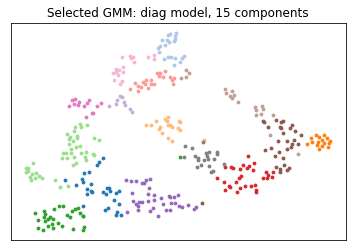

In [345]:
# X = umap.UMAP(n_components=4).fit_transform(X)
# anomalies = gmm_anomalies(data, best_gmm.predict_proba(X), 0.99)
# anomalies = dbscan_anomalies(labels)
# print(anomalies)
# print(lof_anomalies(data,X))

# generate plot using TSNE
plot_tsne(best_gmm, X, Y, data["text"])

In [346]:
texts = data["text"].take(np.argwhere(Y==6).flatten())
stars = data["stars"].take(np.argwhere(Y==6).flatten())

# for t,s in zip(texts,stars):
#     print("START--------------------")
#     print(s, t)
#     print("END----------------------\n")

# Cluster Summarization

In [316]:
def read_article(texts):
    combined_text = ' '.join(texts)
    reviews = combined_text.split(". ")
    sentences = []
    for sentence in reviews:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix

def generate_summary(texts, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []
    # Step 1 - Read text and tokenize
    sentences =  read_article(texts)
    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph, max_iter=100)
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
#     print("Indexes of top ranked_sentence order are ", ranked_sentence)
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
        # Step 5 - Offcourse, output the summarize texr
    return ". ".join(summarize_text)

In [351]:
for c in range(15):
    indices = np.argwhere(Y == c).flatten()
    mean = data["stars"].take(indices).sum() / len(indices)
    print("Cluster {}: {} reviews and avg. rating of {}:".format(c, len(indices), mean))

Cluster 0: 29 reviews and avg. rating of 4.620689655172414:
Cluster 1: 21 reviews and avg. rating of 4.380952380952381:
Cluster 2: 16 reviews and avg. rating of 2.875:
Cluster 3: 19 reviews and avg. rating of 3.736842105263158:
Cluster 4: 31 reviews and avg. rating of 4.387096774193548:
Cluster 5: 46 reviews and avg. rating of 4.413043478260869:
Cluster 6: 31 reviews and avg. rating of 4.387096774193548:
Cluster 7: 21 reviews and avg. rating of 4.523809523809524:
Cluster 8: 38 reviews and avg. rating of 4.5:
Cluster 9: 9 reviews and avg. rating of 2.7777777777777777:
Cluster 10: 32 reviews and avg. rating of 4.21875:
Cluster 11: 20 reviews and avg. rating of 4.35:
Cluster 12: 14 reviews and avg. rating of 4.285714285714286:
Cluster 13: 18 reviews and avg. rating of 4.444444444444445:
Cluster 14: 21 reviews and avg. rating of 4.333333333333333:


In [356]:
print("Summary of cluster 9, avg. rating=2.77")
cluster_text = data["text"].take(np.argwhere(Y==9).flatten()).tolist()
summary = generate_summary(cluster_text, top_n=8)
print(summary)

print("Summary of cluster 0, avg. rating=4.62")
cluster_text = data["text"].take(np.argwhere(Y==0).flatten()).tolist()
summary = generate_summary(cluster_text, top_n=8)
print(summary)

Summary of cluster 9, avg. rating=2.77
 It's certainly not something I'd wait in line for.  I wouldn't wait an hour for an above average burger ever.  Was it the best burger I have had in my entire life?  No. I even watched a lady pass out from the heat!


 The burger is good but not a 3 1/2 hour wait kinda burger.  Congrats. Cannot believe all the idiots who wait in line for this place ~ what is the big deal ? I found the burger nice and tasty but I don't see what all the fuss is about. The wait time is crazy 3 1/2 hours!!! They need to develop a better system than to have people wait in line.  I just don't like the idea that I may die of starvation waiting in line :( Nothing special here, It was alright
Summary of cluster 0, avg. rating=4.62
 
If you're like me and get tired of American food quickly, you can still grub here and love it!  The fries were on point, the burger was on point and the beer was on point!

What more could you ask for?  Hop in your car and go to Hopdoddy's! We 